In [26]:
# Section 1: Import Libraries and Setup
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import os

In [27]:
# Section 2: Preprocessing - Prepare Image Data Generators
train_dir = 'Split_Data/train'
val_dir = 'Split_Data/val'
test_dir = 'Split_Data/test'

In [28]:
# Set up ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6266 images belonging to 9 classes.
Found 1342 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.


In [29]:
# Section 3: Build Model
# Replace ResNet50 with:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,981,961 (57.15 MB)

 Trainable params: 267,273 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
# Section 4: Training Utilities
class EpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss'):
        super().__init__()
        self.monitor = monitor
        self.best_epoch = 0
        self.best_value = float('inf') if monitor == 'val_loss' else -float('inf')
    
    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.monitor)
        if (self.monitor == 'val_loss' and current_value < self.best_value) or \
           (self.monitor != 'val_loss' and current_value > self.best_value):
            self.best_value = current_value
            self.best_epoch = epoch + 1
    
    def on_train_end(self, logs=None):
        print(f"Best epoch: {self.best_epoch} with {self.monitor}: {self.best_value:.4f}")

In [31]:
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.2655 - loss: 2.0009 - val_accuracy: 0.5175 - val_loss: 1.4430 - learning_rate: 0.0010
Epoch 2/30
  1/195 ━━━━━━━━━━━━━━━━━━━━ 6:20 2s/step - accuracy: 0.4375 - loss: 1.5237

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4375 - loss: 1.5237 - val_accuracy: 0.4000 - val_loss: 1.4674 - learning_rate: 0.0010
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.5341 - loss: 1.3716 - val_accuracy: 0.6761 - val_loss: 1.0563 - learning_rate: 0.0010
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6562 - loss: 1.2733 - val_accuracy: 0.6333 - val_loss: 1.0731 - learning_rate: 0.0010
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.6160 - loss: 1.1359 - val_accuracy: 0.7180 - val_loss: 0.9329 - learning_rate: 0.0010
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6562 - loss: 0.9969 - val_accuracy: 0.7000 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.6529 - loss: 1.0289 - val_accuracy: 0.7096 - val_loss: 0.8855 - learning_rate: 0.0010
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6250 - loss: 0.9064 - val_

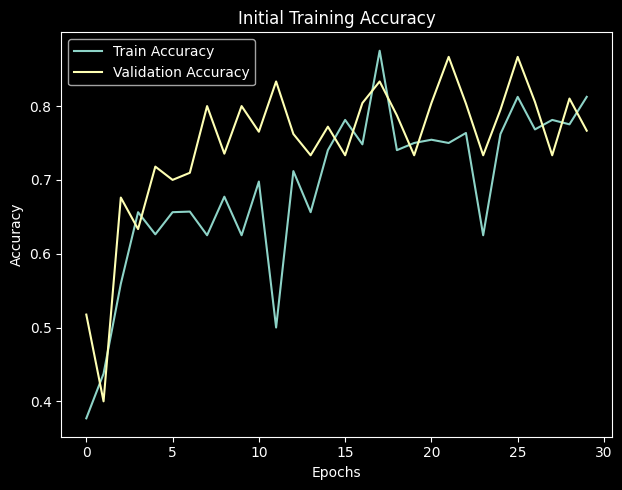

In [32]:
# Section 5: Initial Training
initial_callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('initial_model_EfficientNetV2B0.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    EpochLogger('val_loss')
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=initial_callbacks
)

plot_training_history(history, 'Initial Training')

Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 586s 3s/step - accuracy: 0.7712 - loss: 0.6659 - val_accuracy: 0.8077 - val_loss: 0.6053 - learning_rate: 1.0000e-04
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 586s 3s/step - accuracy: 0.7720 - loss: 0.6603 - val_accuracy: 0.8085 - val_loss: 0.6012 - learning_rate: 1.0000e-04
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 558s 3s/step - accuracy: 0.7634 - loss: 0.6614 - val_accuracy: 0.8003 - val_loss: 0.6221 - learning_rate: 1.0000e-04
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 554s 3s/step - accuracy: 0.7758 - loss: 0.6450 - val_accuracy: 0.8077 - val_loss: 0.5968 - learning_rate: 1.0000e-04
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - accuracy: 0.7828 - loss: 0.6272 - val_accuracy: 0.8137 - val_loss: 0.5902 - learning_rate: 1.0000e-04
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.7808 - loss: 0.6267 - val_accuracy: 0.8100 - val_loss: 0.5866 - learning_rate: 1.0000e-04
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - acc

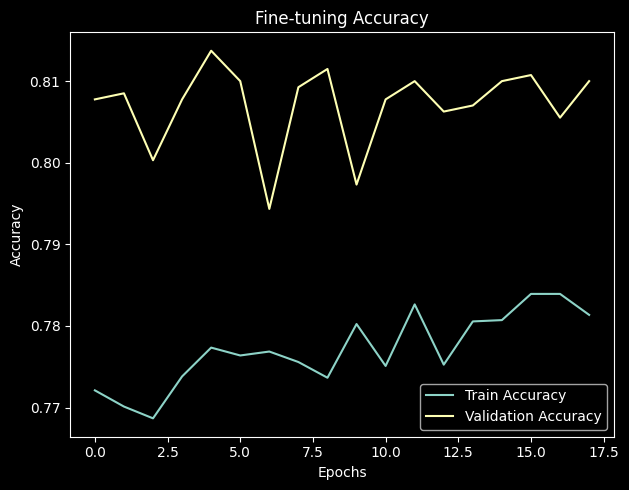

In [33]:
# Section 6: Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:150]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Class weighting system
class_weights = {idx: 0.5 if cls == 'Tomato_healthy' else 1.0 
                 for cls, idx in train_generator.class_indices.items()}

# Weighted generator
def add_sample_weights(generator, class_weight_dict):
    for x, y in generator:
        y_classes = np.argmax(y, axis=1)
        sample_weights = np.array([class_weight_dict[cls] for cls in y_classes])
        yield x, y, sample_weights

fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('fine_tuned_model_EfficientNetV2B0.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    EpochLogger('val_accuracy')
]

history_ft = model.fit(
    add_sample_weights(train_generator, class_weights),
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=val_generator,
    callbacks=fine_tune_callbacks
)

plot_training_history(history_ft, 'Fine-tuning')
model.save('final_fine_tuned_model_EfficientNetV2B0.keras')

42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step

Classification Report:
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.88      0.91      0.89       150
                        Tomato_Early_blight       0.73      0.70      0.72       150
                         Tomato_Late_blight       0.91      0.78      0.84       150
                           Tomato_Leaf_Mold       0.86      0.84      0.85       144
                  Tomato_Septoria_leaf_spot       0.79      0.79      0.79       150
Tomato_Spider_mites_Two_spotted_spider_mite       0.66      0.93      0.77       150
                        Tomato__Target_Spot       0.76      0.73      0.75       150
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.92      0.92      0.92       150
                             Tomato_healthy       0.97      0.77      0.86       150

                                   accuracy                           0.82      1344


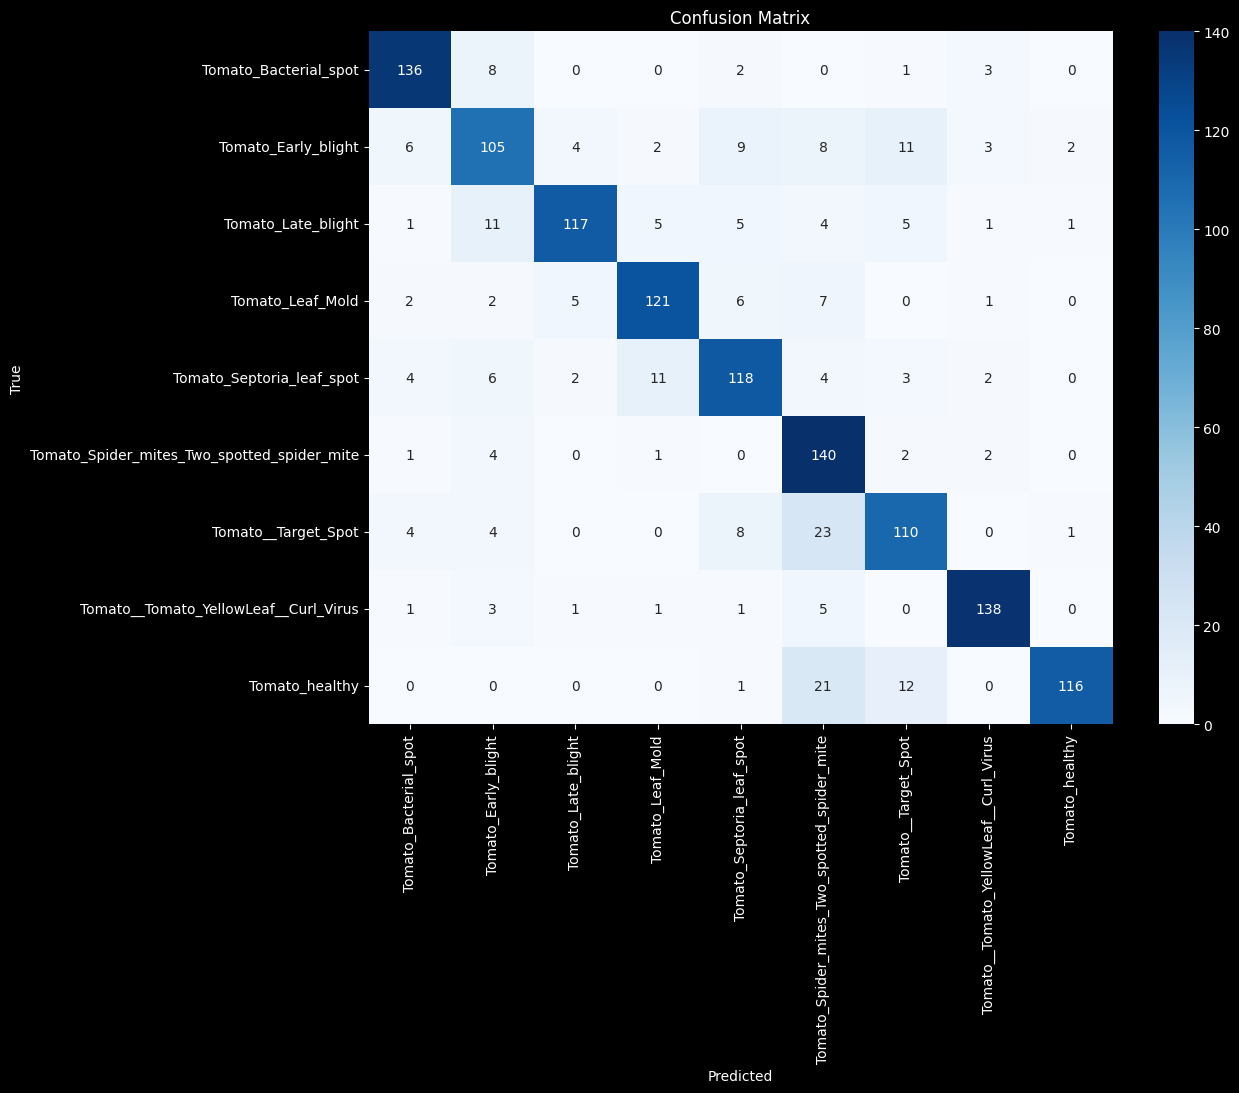

In [34]:
# Section 7: Evaluation
test_steps = (test_generator.samples + test_generator.batch_size - 1) // test_generator.batch_size
y_pred = model.predict(test_generator, steps=test_steps)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
plt.figure(figsize=(12, 9))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()